# Sudoku Grid Detection

In [ ]:
using Images
using ImageFiltering
using ImageBinarization
using Plots

In [ ]:
using Revise
Revise.includet("../ImageContours/src/ImageContours.jl");
using .ImageContours
Revise.includet("../GridDetection/PerspectiveTransformations.jl")
using .PerspectiveTransformations
includet("../utilities/invert_image.jl")

## Load image

In [ ]:
image_path = "../images/sudoku_pyimagesearch.jpg";

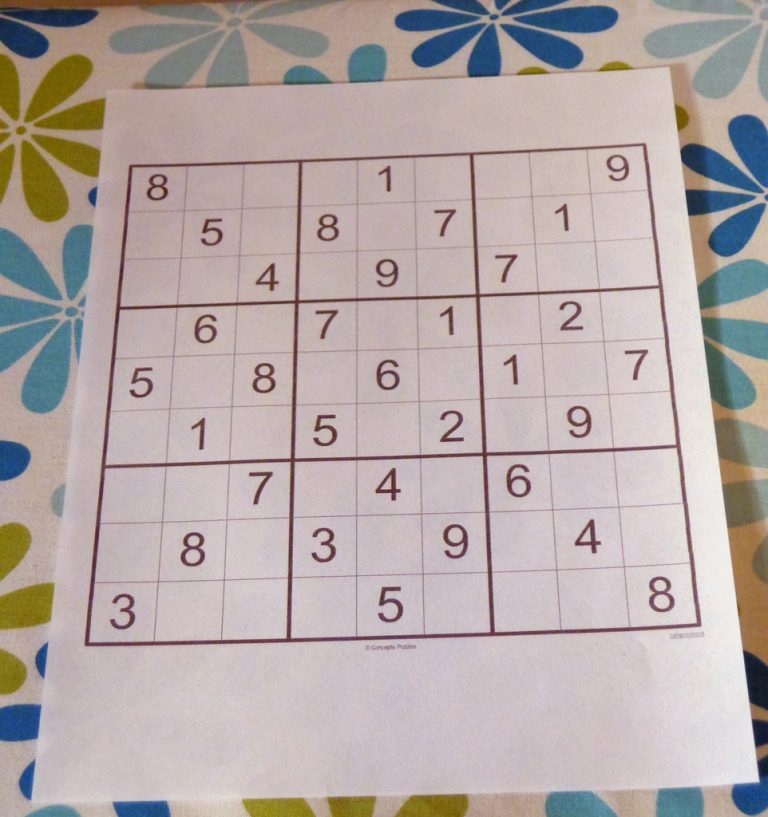

In [ ]:
image_raw = load(image_path)
image = copy(image_raw)

max_size = 1024 
ratio = max_size/size(image, argmax(size(image)))
if ratio < 1
    image = imresize(image, ratio=ratio)
end

image_raw

## Preprocess

In [ ]:
window_size = 5;
σ = 1 # 0.3*((window_size - 1) * 0.5 - 1) + 0.8  # OpenCV default

1

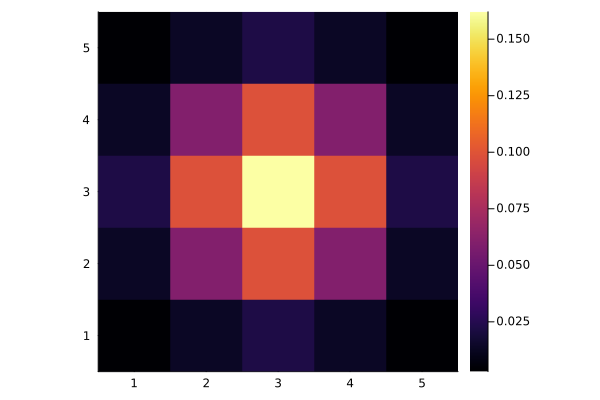

In [ ]:
kernel = Kernel.gaussian((σ, σ), (window_size, window_size))
heatmap(1:window_size, 1:window_size, kernel, aspectratio=1, xlims=(0.5, 5.5))

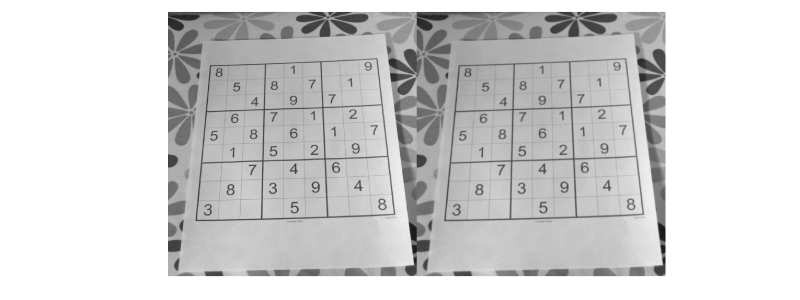

In [ ]:
kernel = Kernel.gaussian((σ, σ), (window_size, window_size))
img_gray = Gray.(image)
img_gray = imfilter(img_gray, kernel)
plot(hcat(Gray.(image), img_gray),  size = (800, 300), border=:none)

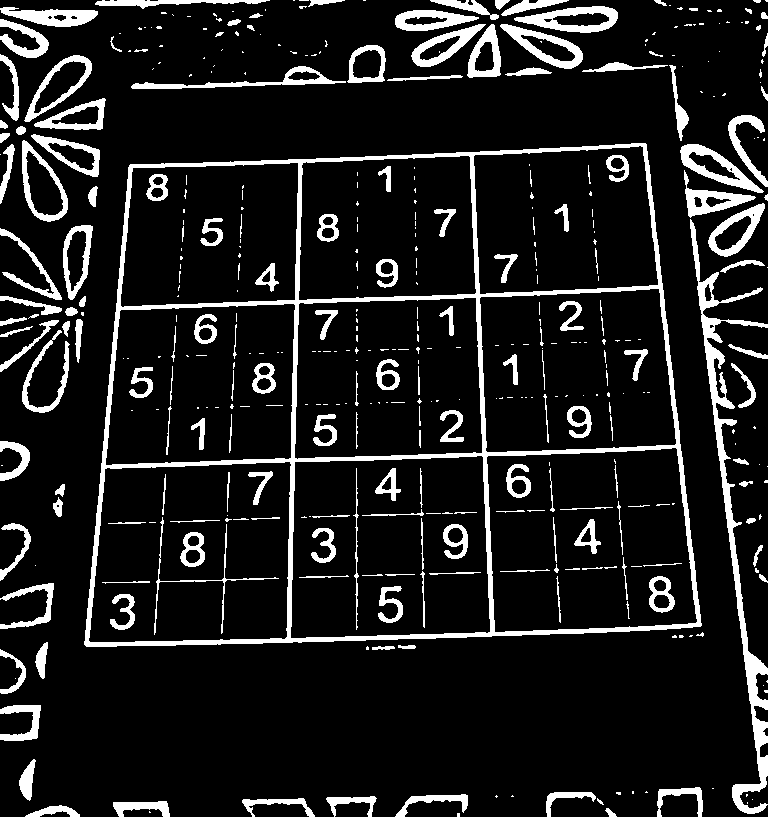

In [ ]:
blackwhite = binarize(img_gray, AdaptiveThreshold(window_size=15, percentage=7))
blackwhite = invert_image(blackwhite)
blackwhite

## Contours

487
  0.040635 seconds (216.04 k allocations: 6.140 MiB, 80.84% compilation time)
  0.002947 seconds (79.12 k allocations: 1.845 MiB)


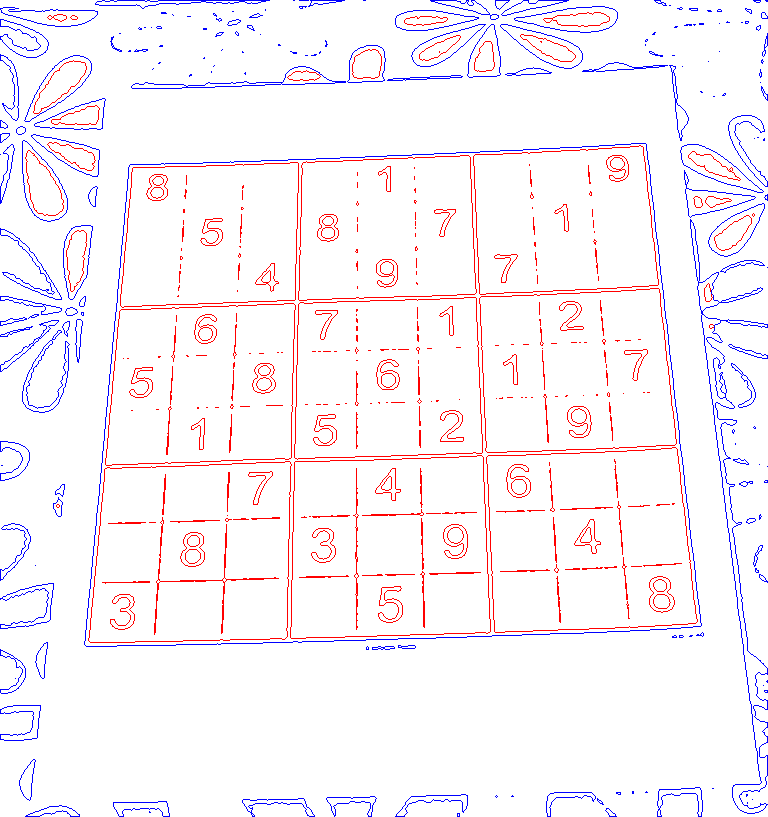

In [ ]:
contours = find_contours(blackwhite)
println(length(contours))
img_contours = ones(RGB, size(image)) # copy(image)
@time draw_contours!(img_contours, contours, RGB(1,0,0))
contours = find_contours(blackwhite, external_only=true)
@time draw_contours!(img_contours, contours, RGB(0,0,1))
img_contours

  0.820285 seconds (3.35 M allocations: 160.468 MiB, 5.46% gc time, 76.38% compilation time)


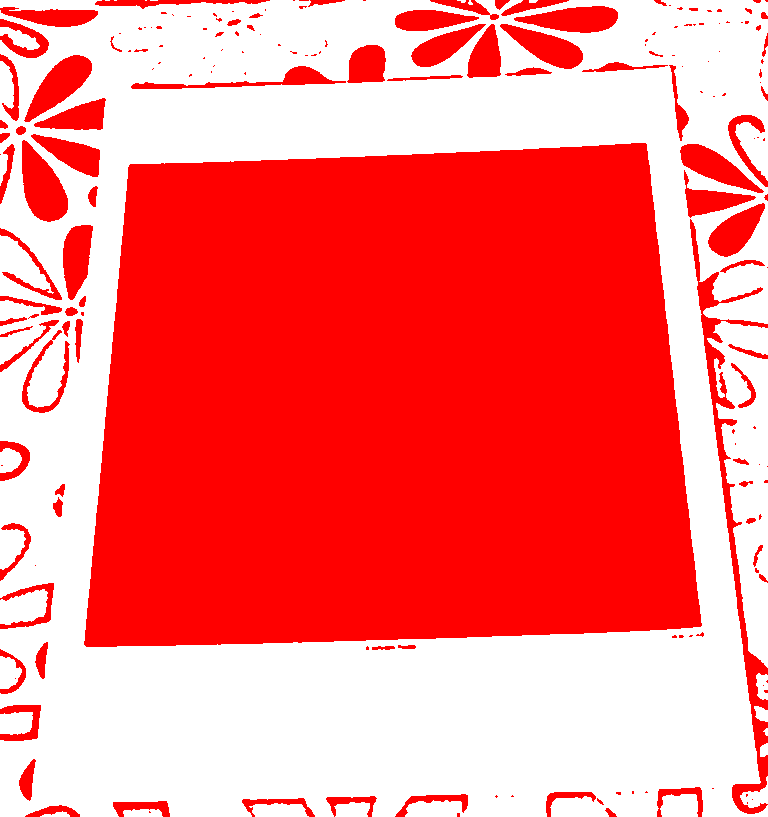

In [ ]:
contours = find_contours(blackwhite, external_only=true)
img_contours = ones(RGB, size(image)) # copy(image)
@time fill_contours!(img_contours, contours, RGB(1,0,0))
img_contours

## Fit Rectangle

In [ ]:
idx_max = argmax(map(area_contour, contours))
max_contour = contours[idx_max]
print(length(max_contour))
rect = fit_rectangle(max_contour)
quad = fit_quad(max_contour)

2094

4-element Vector{CartesianIndex{2}}:
 CartesianIndex(165, 131)
 CartesianIndex(645, 85)
 CartesianIndex(627, 701)
 CartesianIndex(145, 647)

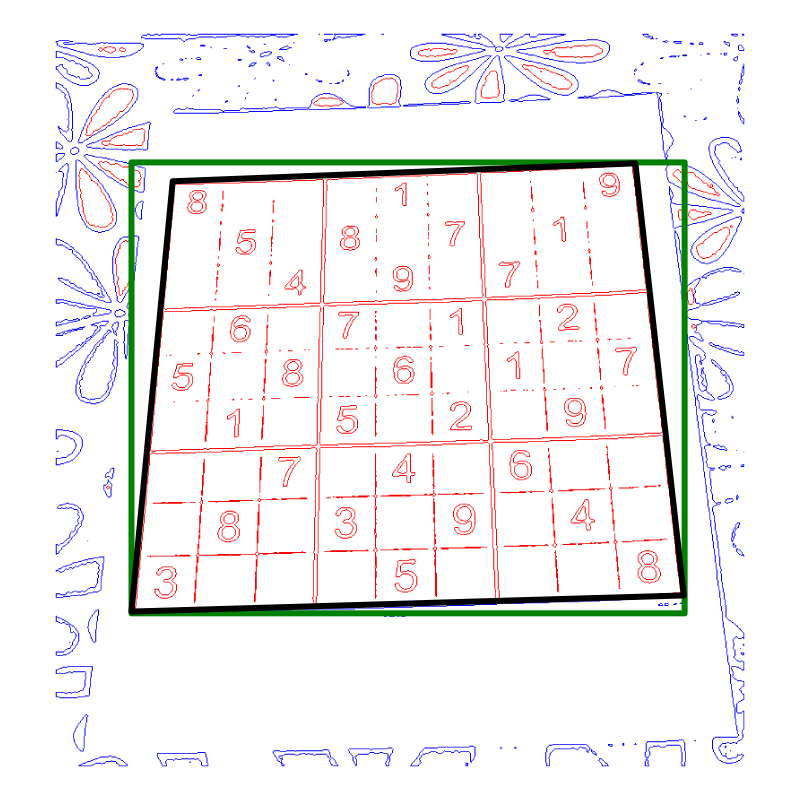

In [ ]:
contours = find_contours(blackwhite)
img_contours = ones(RGB, size(image)) # copy(image)
draw_contours!(img_contours, contours, RGB(1,0,0))
contours = find_contours(blackwhite, external_only=true)
draw_contours!(img_contours, contours, RGB(0,0,1))

p = plot(img_contours, size=(800, 800))
plot!(p, 
    [point[2] for point in vcat(rect, rect[1])], [point[1] for point in vcat(rect, rect[1])], 
    linewidth=6, label="", color=:Green
    )
plot!(p, 
    [point[2] for point in vcat(quad, quad[1])], [point[1] for point in vcat(quad, quad[1])], 
    linewidth=6, label="", color=:black
    )
plot!(border=:none, ticks=nothing)

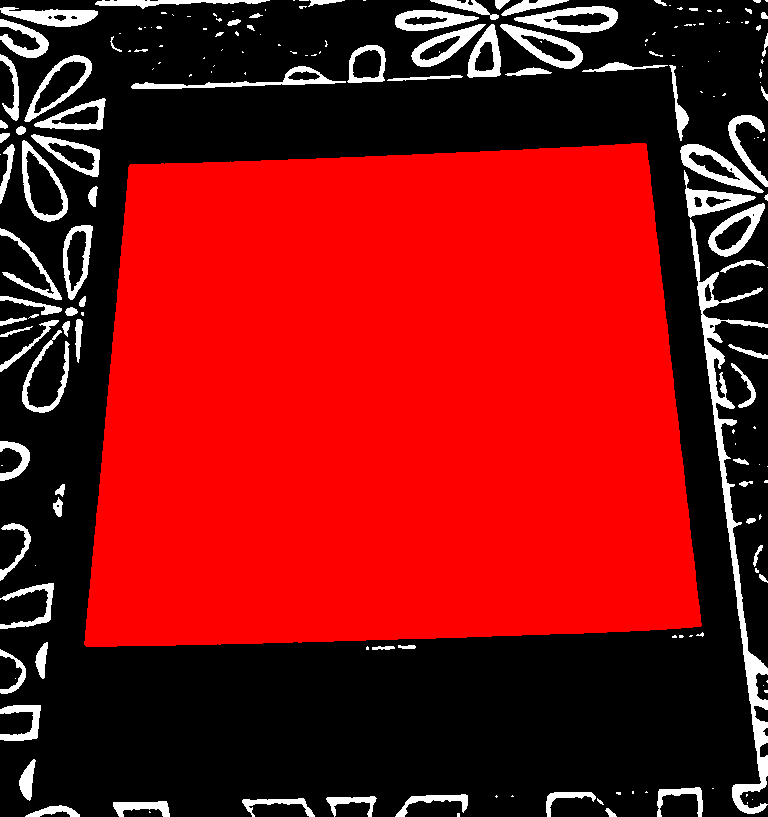

In [ ]:
img_contours = RGB.(blackwhite)
fill_contour!(img_contours, max_contour, RGB(1, 0, 0))
img_contours

In [ ]:
function apply_mask(image, mask)
    height, width = size(image)
    T = typeof(image).parameters[1]
    masked_image = zeros(T, size(image))
    for i in 1:height
        for j in 1:width
            masked_image[i, j] = mask[i, j] > 0 ? image[i, j] : zero(T)
        end
    end
    masked_image
end

apply_mask (generic function with 1 method)

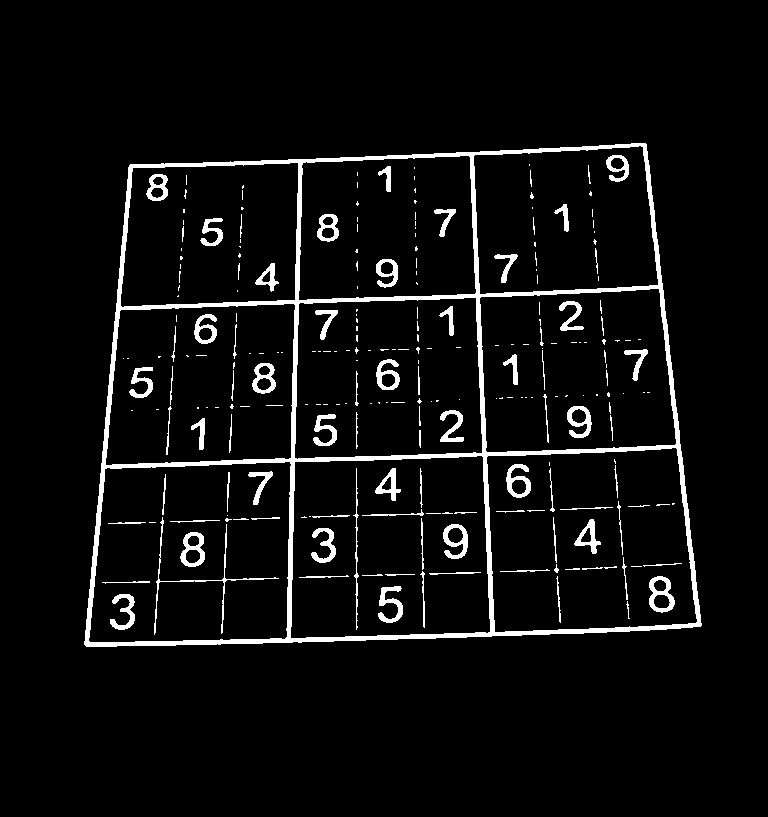

In [ ]:
mask = zeros(size(image))
fill_contour!(mask, max_contour, 1)
masked_image = apply_mask(blackwhite, mask)
masked_image

## Straighten grid

In [ ]:
using ImageTransformations, CoordinateTransformations

In [ ]:
rect = fit_rectangle(quad)
rect_offset = [CartesianIndex(point[1] - rect[1][1] + 1, point[2] - rect[1][2] + 1) for point in rect]
rect_offset

4-element Vector{CartesianIndex{2}}:
 CartesianIndex(1, 1)
 CartesianIndex(501, 1)
 CartesianIndex(501, 617)
 CartesianIndex(1, 617)

  0.982451 seconds (3.82 M allocations: 196.857 MiB, 4.28% gc time, 80.76% compilation time)


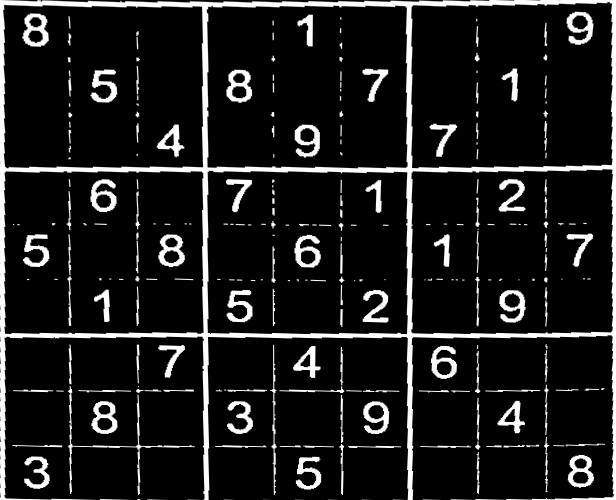

In [ ]:
@time warped, invM = four_point_transform(blackwhite, quad)
warped

## Test warping back

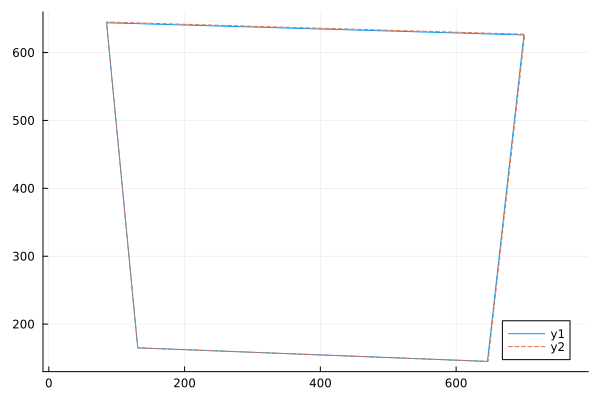

In [ ]:
height, width = size(warped)
corners = [(1, 1), (1, width), (height, width), (height, 1)]
warped_corners = []
for corner in corners
    warped_corner = perspective_transform(invM)(corner)
    push!(warped_corners, warped_corner)
end
y = [point[1] for point in warped_corners]
x = [point[2] for point in warped_corners]
plot(vcat(x, x[1]), vcat(y, y[1]), aspectratio=1)

y = [point[1] for point in quad]
x = [point[2] for point in quad]
plot!(vcat(x, x[1]), vcat(y, y[1]), linestyle=:dash)

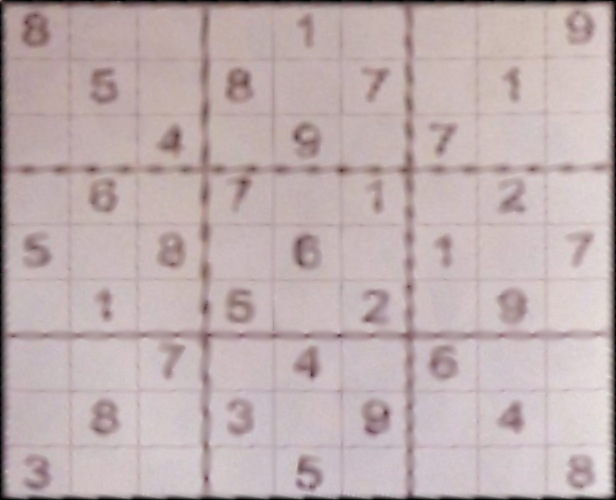

In [ ]:
image_orig = copy(image)
height_orig, width_orig = size(image_orig)

image_warp, invM = four_point_transform(image, quad)
height_warp, width_warp = size(image_warp)
M = inv(invM)

for i in 1:50
    image_orig = warp(image_warp, perspective_transform(M), (1:width_orig, 1:height_orig))
    image_warp = warp(image_orig, perspective_transform(invM), (1:height_warp, 1:width_warp))
end
image_warp